In [1]:
import nbpresent
nbpresent.__version__

'3.0.2'

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


# Analysis of the measurements of device TD1606 in Orsay

## To do list:

1. See if the Abrikosov Gorkov model helps fit the parallel field data.
5. Put a linear line on the filed dependent zero bias conductance. Maybe try to say something on the a limit to the anisotropy in the AB plane.



In [86]:
## FMcMillen model functions

import numpy
import matplotlib.pyplot as plt
import matplotlib as mpl
from cmath import sqrt
import time 
from lmfit import Parameters, minimize, fit_report
import scipy.io
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch

%matplotlib inline

def FermiDirac(E,T):
    return numpy.array(1 / (1 + numpy.exp(E / T)))

def SelfConsEq(Delta,E,Delta0,Gamma):
    if Delta[0].imag > 0:
        Delta[0] = Delta[0].conjugate()
    if Delta[1].imag > 0:
        Delta[1] = Delta[1].conjugate()

    NewDelta = numpy.ndarray(2,complex)
    NewDelta[0] = (Delta0[0] + Gamma[0] * Delta[1] / sqrt(Delta[1]**2 - E**2))/ \
         (1  + Gamma[0] / sqrt(Delta[1] ** 2 - E ** 2))
    NewDelta[1] = (Delta0[1] + Gamma[1] * Delta[0] / sqrt(Delta[0]**2 - E**2))/ \
         (1  + Gamma[1] / sqrt(Delta[0] ** 2 - E ** 2))

    return NewDelta

def Iterations(prevDelta,E,Delta0,Gamma):
    errors = numpy.array([1,1])
    index = 0
    prevDelta = prevDelta + 0.1*1j
    while (max(abs(errors))> 1e-6 ) and (index < 1e1):
        index = index+1
        newDelta = SelfConsEq(prevDelta,E,Delta0,Gamma)
        errors = prevDelta - newDelta
        prevDelta = newDelta
    return newDelta, errors

def CalculateDOS(Energys,Delta0,Gamma,Neff):
    
    Neff = numpy.array(Neff)
    Gamma = numpy.array(Gamma)
    Delta0 = numpy.array(Delta0)
    Energys = numpy.array(Energys)
    
    initDelta = numpy.array([0.5-0.1*1j, 0 + 0.1*1j])
    sol , err = Iterations(initDelta,0,Delta0,Gamma)
    
    Ns = [0]*(len(Energys))
    Deltas = [0]*(len(Energys))
    errors = [0]*(len(Energys))
    N = numpy.ndarray(len(Energys))
    
    for k in range(len(Energys)):
        initDelta = sol
        sol , err = Iterations(initDelta,Energys[k],Delta0,Gamma)
        Deltas[k] = sol
        errors[k] = err
        Ns[k] = Neff * (Energys[k]/(Energys[k]**2 - sol**2 )**0.5).real
        N[k] = sum(Ns[k])
   
    return N

def IofV(Vs,Delta0,Gamma,Neff,T):
    energys = numpy.linspace(0,6,1000)
    N = CalculateDOS(energys,Delta0,Gamma,Neff)
    
    energys = numpy.concatenate([numpy.flipud(-energys),energys])
    N = numpy.concatenate([numpy.flipud(N),N])
    N = N/N[0]
    

    Is = numpy.ndarray(len(Vs))


    FDS = FermiDirac(energys,T)
    for k in range(len(Vs)):
        FDN = FermiDirac(energys-Vs[k],T)
        Is[k] = sum(N * (FDN - FDS))
    
    slope = (sum(FermiDirac(energys-Vs[len(Vs)-1],T) - FDS) - sum(FermiDirac(energys-Vs[0],T) - FDS))/(Vs[len(Vs)-1]- Vs[0])
    
    return Is/slope


In [87]:
## Data manipulation and fit functions


def LoadandSymmetrizeTemp(index,shift):
    bigdata = scipy.io.loadmat('summary-data.mat')
    tempdata = bigdata['Temperature']    
#     required data
    data = numpy.array(tempdata[0][index-1][1][0][0][0]).transpose()
    V = data[1]
    G = data[2]
 
    return symmetrize(V,G,shift)

def LoadandSymmetrizePerField(index,shift):
    bigdata = scipy.io.loadmat('summary-data.mat')
    PerpFieldData = bigdata['PerpField']
    data = numpy.array(PerpFieldData[0][index-1][0]).transpose()
    V = data[1]
    G = data[2]
    B = 4*(15-(index-1)/3)
 
    return symmetrize(V,G,shift)

def LoadandSymmetrizeParField(index,shift):
    bigdata = scipy.io.loadmat('summary-data.mat')
    PerpFieldData = bigdata['ParFieldwComp']
    data = numpy.array(PerpFieldData[0][index-1][0]).transpose()
    V = data[1]
    G = data[2]
    B = bigdata['ParFieldwComp'][0][index-1][1][0][0]
    V, G, Gasym = symmetrize(V,G,shift)
    return V, G, Gasym ,B


def symmetrize(V,G,shift):
    bigdata = scipy.io.loadmat('summary-data.mat')
    tempdata = bigdata['Temperature']
    
#     high temp data
    data = numpy.array(tempdata[0][9][1][0][0][0]).transpose()
    Vhigh = data[1]
    Ghigh = data[2]
    
#     dividing the low T by the High T
    GhighI = interp1d(Vhigh,Ghigh)(V)
    Gnew = G / GhighI

#     shifting the voltgae to correct for zero drift
    V = V + shift

    Gflip = interp1d(V,numpy.flipud(Gnew))(V)
    Gsym = (Gnew+Gflip)/2;
    Gasym = (Gnew-Gflip)/2;
 
    return V,Gsym,Gasym    

def LoadFitPlot(V,G,params,Vlim):
        
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    Vs = numpy.linspace(min(V),max(V),300)
    I = IofV(Vs,Delta0,Gamma,Neff,T)
    
    fig = plt.figure(figsize=(8, 8), dpi=80)
    plt.subplot(2, 1, 1)

    plt.plot(V,G,color = 'black',label = 'data',marker = 's',markersize = 2.5,linewidth = 0)
    plt.plot(Vs[0:len(Vs)-1],numpy.diff(I)/numpy.diff(Vs),'r',linewidth=1.5,label = 'fit')
    plt.xlim(Vlim[0], Vlim[1])
    plt.ylim(0,2)
    plt.legend()
    plt.xlabel('V (mV)')
    plt.ylabel('G (a.u.)')

    plt.subplot(2, 1, 2)
    plt.plot(V[1:len(V)],numpy.diff(G)/numpy.diff(V),color = 'black',label = 'data',marker = 's',\
             markersize = 2.5,linewidth = 0)
    plt.plot(Vs[1:len(Vs)-1],numpy.diff(I,2)/(numpy.diff(Vs[1:len(Vs)])**2),'r',linewidth=1.5,label = 'fit')
    plt.xlim(Vlim[0], Vlim[1])
    plt.legend()
    plt.xlabel('V (mV)')
    plt.ylabel('dG/dV (a.u.)')

    plt.show()
    
    return fig

def LoadFitPlotG(axes,V,G,params,Vlim,dGdV = False,shift = 0.,Logscale = False):
        
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    Vs = numpy.linspace(min(V),max(V),300)
    I = IofV(Vs,Delta0,Gamma,Neff,T)
    
    axes.plot(V,G + shift ,color = 'black',label = 'data',marker = 's',markersize = 3,linewidth = 0)
    axes.plot(Vs[0:len(Vs)-1],shift + numpy.diff(I)/numpy.diff(Vs),'r',linewidth=1.5,label = 'fit')
    axes.set_xlim([Vlim[0], Vlim[1]])
#     axes.set_ylim([0,2])
#     axes.legend()
    axes.set_xlabel('V (mV)')
    axes.set_ylabel('G (a.u.)')
    
    if dGdV == True:
        t_axes = inset_axes(axes, width="30%", height=1.3,loc=3)
        t_axes.plot(V[1:len(V)],numpy.diff(G)/numpy.diff(V),color = 'black',label = 'data',marker = 's',\
             markersize = 2.5,linewidth = 0)
        t_axes.plot(Vs[1:len(Vs)-1],numpy.diff(I,2)/(numpy.diff(Vs[1:len(Vs)])**2),'r',linewidth=1.5,label = 'fit')
        t_axes.set_xlim([Vlim[0], Vlim[1]])
        t_axes.get_xaxis().set_ticks([])
        t_axes.get_yaxis().set_ticks([])

    if Logscale == True:
        t_axes = inset_axes(axes, width="30%", height=1.3,loc=4)
        t_axes.plot(V,G,color = 'black',label = 'data',marker = 's',\
             markersize = 2.5,linewidth = 0)
        t_axes.plot(Vs[0:len(Vs)-1],shift + numpy.diff(I)/numpy.diff(Vs),'r',linewidth=1.5,label = 'fit')
        t_axes.set_xlim([Vlim[0], Vlim[1]])
        t_axes.get_xaxis().set_ticks([])
        t_axes.get_yaxis().set_ticks([])
        t_axes.set_ylim([1e-3,3])
        t_axes.set_yscale('log')
        
def LoadFitPlotdGdV(axes,V,G,params,Vlim,shift = 0.):
        
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    Vs = numpy.linspace(min(V),max(V),300)
    I = IofV(Vs,Delta0,Gamma,Neff,T)
    
    
    axes.plot(V[1:len(V)],numpy.diff(G)/numpy.diff(V)+ shift,color = 'black',label = 'data',marker = 's',\
             markersize = 2.5,linewidth = 0)
    axes.plot(Vs[1:len(Vs)-1],numpy.diff(I,2)/(numpy.diff(Vs[1:len(Vs)])**2)+ shift,'r',linewidth=1.5,label = 'fit')
    axes.set_xlim([Vlim[0], Vlim[1]])
#     axes.set_ylim([0,2])
#     axes.legend()
    axes.set_xlabel('V (mV)')
    axes.set_ylabel('dG/dV (a.u.)')




def Goodness(params,V,G,Gerr,Vlim):
    
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    Vfit = numpy.linspace(-6,6,500)
    I = IofV(Vfit,Delta0,Gamma,Neff,T)
    Gfit = numpy.diff(I)/numpy.diff(Vfit)

#  trimming:
    Vmin = Vlim[0]
    Vmax = Vlim[1]
    MinIndex = numpy.argmin(abs(V-Vmin))
    MaxIndex = numpy.argmin(abs(V-Vmax))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    Gerr = Gerr[MinIndex:MaxIndex]

    GforChi = interp1d(Vfit[1:len(Vfit)],Gfit)(V)
    
    return (GforChi-G)/Gerr

def Goodness2(params,V,G,Gerr,Vlim):
    
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    Vfit = numpy.linspace(-6,6,500)
    I = IofV(Vfit,Delta0,Gamma,Neff,T)
    Gfit = numpy.diff(I)/numpy.diff(Vfit)

#  trimming:
    Vmin = Vlim[0]
    Vmax = Vlim[1]
    MinIndex = numpy.argmin(abs(V-Vmin))
    MaxIndex = numpy.argmin(abs(V-Vmax))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    Gerr = Gerr[MinIndex:MaxIndex]

    GforChi = interp1d(Vfit[1:len(Vfit)],Gfit)(V)
    
    
    return (numpy.diff(GforChi)-numpy.diff(G))/Gerr[1:len(G)]

def VortexFit(Vparams,V,G,Gerr,Vlim):
    a = Vparams['a'].value
    b = Vparams['b'].value
    c = Vparams['c'].value    
    V0 = Vparams['V0'].value
    
    Vmin = Vlim[0]
    Vmax = Vlim[1]
    MinIndex = numpy.argmin(abs(V-Vmin))
    MaxIndex = numpy.argmin(abs(V-Vmax))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    Gerr = Gerr[MinIndex:MaxIndex]
    
    Gfit = a*(V-V0)**2+b*abs((V-V0))+c

    return (Gfit-G)/Gerr

In [88]:
## Assisting functions for using the lmfit package

def makeParamaters(dataline):
    params = Parameters()
    params.add('Delta01', value=dataline[0], min = 0.0, vary = True)
    params.add('Delta02', value=dataline[1], min = 0.0, vary = True)
    params.add('Gamma1', value=dataline[2], min = 0.0, vary = True)
    params.add('Gamma2', value=dataline[3], min = 0.0, vary = True)
    params.add('Neff1', value=dataline[4], vary = False)
    params.add('Neff2', value=dataline[5], min = 0.0, vary = True)
    params.add('T', value=dataline[6], min = 0.0, vary = True)
    return params

def readParameters(params):
    dataline = numpy.ndarray(7)
    dataline[0] = params['Delta01'].value
    dataline[1] = params['Delta02'].value
    dataline[2] = params['Gamma1'].value
    dataline[3] = params['Gamma2'].value
    dataline[4] = params['Neff1'].value
    dataline[5] = params['Neff2'].value
    dataline[6] = params['T'].value
    return dataline
    
def makeVParamaters(dataline):
    params = Parameters()
    params.add('a', value=dataline[0], min = 0.0, vary = False)
    params.add('b', value=dataline[1], min = 0.0, vary = True)
    params.add('c', value=dataline[2], min = 0.0, vary = True)    
    params.add('V0', value=dataline[3], vary = True)
    return params

def readVParameters(params):
    dataline = numpy.ndarray(4)
    dataline[0] = params['a'].value
    dataline[1] = params['b'].value
    dataline[2] = params['c'].value
    dataline[3] = params['V0'].value
    return dataline

   

In [99]:
# Load data from file

AllData = numpy.load('AnalysisData.npy')

Tempdata = AllData[()]['TempData']
TempdataRaw = AllData[()]['TempDataRaw']
Tsample = AllData[()]['Tsample']
FitNoDelta2 = AllData[()]['FitNoDelta2']
FitNoDelta2Raw = AllData[()]['FitNoDelta2Raw']
FitFixedT200mK = AllData[()]['FitFixedT200mK'] 
FitFixedT200mKRaw  = AllData[()]['FitFixedT200mKRaw']  

PerFieldData = AllData[()]['PerFieldData']
PerFielddataRaw = AllData[()]['PerFieldDataRaw']
PerFieldLinFit_0p1 = AllData[()]['PerFieldLinFit_0p1']
PerFieldLinFit_0p2 = AllData[()]['PerFieldLinFit_0p2']
PerFieldLinFit_0p3 = AllData[()]['PerFieldLinFit_0p3']
PerFieldDataFreeDeltas = AllData[()]['PerFieldDataFreeDeltas']
PerFielddataFreeDeltasRaw = AllData[()]['PerFielddataFreeDeltasRaw']
PerFieldDataFixedGammas = AllData[()]['PerFieldDataFixedGammas'] 
PerFielddataFixedGammasRaw = AllData[()]['PerFielddataFixedGammasRaw']
PerB = AllData[()]['PerB']

ParB = AllData[()]['ParB']
ParFieldLinFit_0p1 = AllData[()]['ParFieldLinFit_0p1']
ParFieldLinFit_0p2 = AllData[()]['ParFieldLinFit_0p2']
ParFieldLinFit_0p3 = AllData[()]['ParFieldLinFit_0p3']

## Figure 1 - Tunneling and temperature dependence

$\bf{(a)}$ Fit of the lowest temperature conductance curve using the McMillen model and allowing all the parameters to be fixed. Fit results : $\Delta_1$ = 1.23 meV, $\Delta_2$ = 0.36 meV, $\Gamma_1$ = 0.38 meV, $\Gamma_2$ = 1.12 meV, $N_\text{Eff2}$ = 0.13, T = 0.52 K. (Inset - the second derivative of the conductance curve)

$\bf{(b)}$ image of the measured device aftr lithography.

$\bf{(c)}$ Conductance curves measured at different temperatures, all fitted to the McMillen model. In this process, $\Gamma_1$, $\Gamma_2$ and $N_\text{Eff2}$ were kept fixed to their low temperature values.

$\bf{(d)}$ Temperature dependence of the order parameters in the different bands. The temperature plotted here is the fitted temperature.


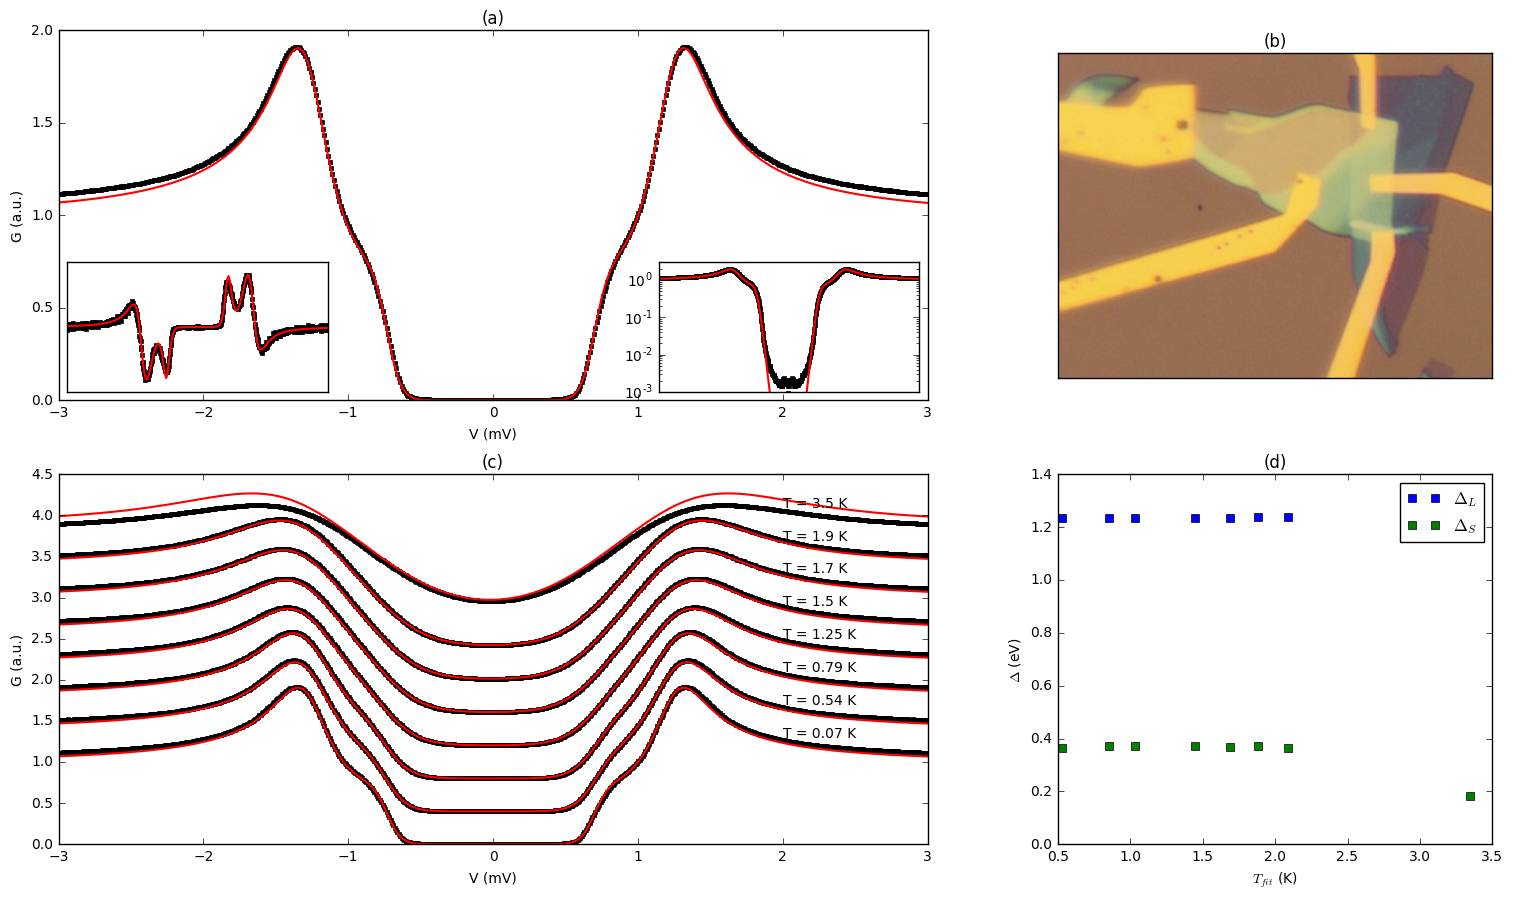

In [7]:
V, G, Gasym = LoadandSymmetrizeTemp(1,0.125)
img = mpimg.imread('device_image.png')

T = Tempdata.transpose()[6]/0.08
Delta01 = Tempdata.transpose()[0]
Delta02 = Tempdata.transpose()[1]



f , axarr = plt.subplots(2,2,gridspec_kw = {'width_ratios':[2, 1]})
f.set_size_inches(18.5, 10.5)
axarr[0,0].set_title('(a)')
axarr[0,1].set_title('(b)')
axarr[1,0].set_title('(c)')
axarr[1,1].set_title('(d)')


axarr[0, 1 ].imshow(img)


axarr[0,1].axes.get_xaxis().set_visible(False)
axarr[0,1].axes.get_yaxis().set_visible(False)

LoadFitPlotG(axarr[0,0],V,G,makeParamaters(Tempdata[0]),[-3,3],True,0,True)


for k in range(1,9):
    V, G, Gasym = LoadandSymmetrizeTemp(k,0.125)
    LoadFitPlotG(axarr[1,0],V,G,makeParamaters(Tempdata[k-1]),[-3,3],False,(k-1)*0.4)
    axarr[1,0].annotate('T = {} K'.format(Tsample[k-1]),xy = (2,1.3+(k-1)*0.4))


axarr[1,1].plot(T,Delta01,label = '$\Delta_L$',marker = 's',\
             markersize = 6,linewidth = 0)
axarr[1,1].plot(T,Delta02,label = '$\Delta_S$',marker = 's',\
             markersize = 6,linewidth = 0)
axarr[1,1].set_xlabel('$T_{fit} $ (K)')
axarr[1,1].set_ylabel('$\Delta $ (eV)')
temp = axarr[1,1].legend()

## Figure 2 - Field analysis

$\bf{(a,b)}$ Conductance ($dI/dV$) amd second derivative ($d^2I/dV^2$) as a function of perpendicular magnetic field and bias voltage. Notice the disappearance of the inner peak in the second derivative.

$\bf{(c,d)}$ Conductance ($dI/dV$) amd second derivative ($d^2I/dV^2$) as a function of parallel magnetic field and bias voltage. Notice the phase transition around 0.5T.

$\bf{(e)}$ The interband tunneling rates ($\Gamma_1$, $\Gamma_2$) as a function of perpendicular magnetic field. This was obtained by fitting the second derivative curves to the McMillen model above the V shape, that is in voltages between 0.5mV and 1.3mV. This fitting was done by fixing $\Delta_1$ and $\Delta_2$ to their zero field low temperature values, and allowing $\Gamma_1$, $\Gamma_2$ to change.

$\bf{(f)}$ Zero bias conductance as a function of perpendicular and parallel magnetic fields.


In [8]:
k = 1
V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
Vs_perp, Gs_perp, Gasym = LoadandSymmetrizePerField(1,-0.035)
dGdVs_perp = numpy.diff(Gs_perp)/numpy.diff(Vs_perp)
Bs_perp = numpy.ones(len(V))*4*(15-(k-1)/3)

for k in range(2,47):
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    dGdV = numpy.diff(G)/numpy.diff(V)
    B = numpy.ones(len(V))*4*(15-(k-1)/3)
    
    Vs_perp = numpy.vstack((Vs_perp, V))
    Gs_perp = numpy.vstack((Gs_perp, G))   
    dGdVs_perp = numpy.vstack((dGdVs_perp, dGdV))
    Bs_perp = numpy.vstack((Bs_perp, B))
    
k = 1
Vs_par, Gs_par, Gasym,B = LoadandSymmetrizeParField(1,-0.035)
V = Vs_par
G = Gs_par
dGdVs_par = numpy.diff(G)/numpy.diff(V)
Bs_par = numpy.ones(len(V))*B

for k in range(2,35):
    V, G, Gasym, B = LoadandSymmetrizeParField(k,-0.035)
    dGdV = numpy.diff(G)/numpy.diff(V)
    
    Vs_par = numpy.vstack((Vs_par, V))
    Gs_par = numpy.vstack((Gs_par, G))   
    dGdVs_par = numpy.vstack((dGdVs_par, dGdV))
    Bs_par = numpy.vstack((Bs_par, numpy.ones(len(V))*B))

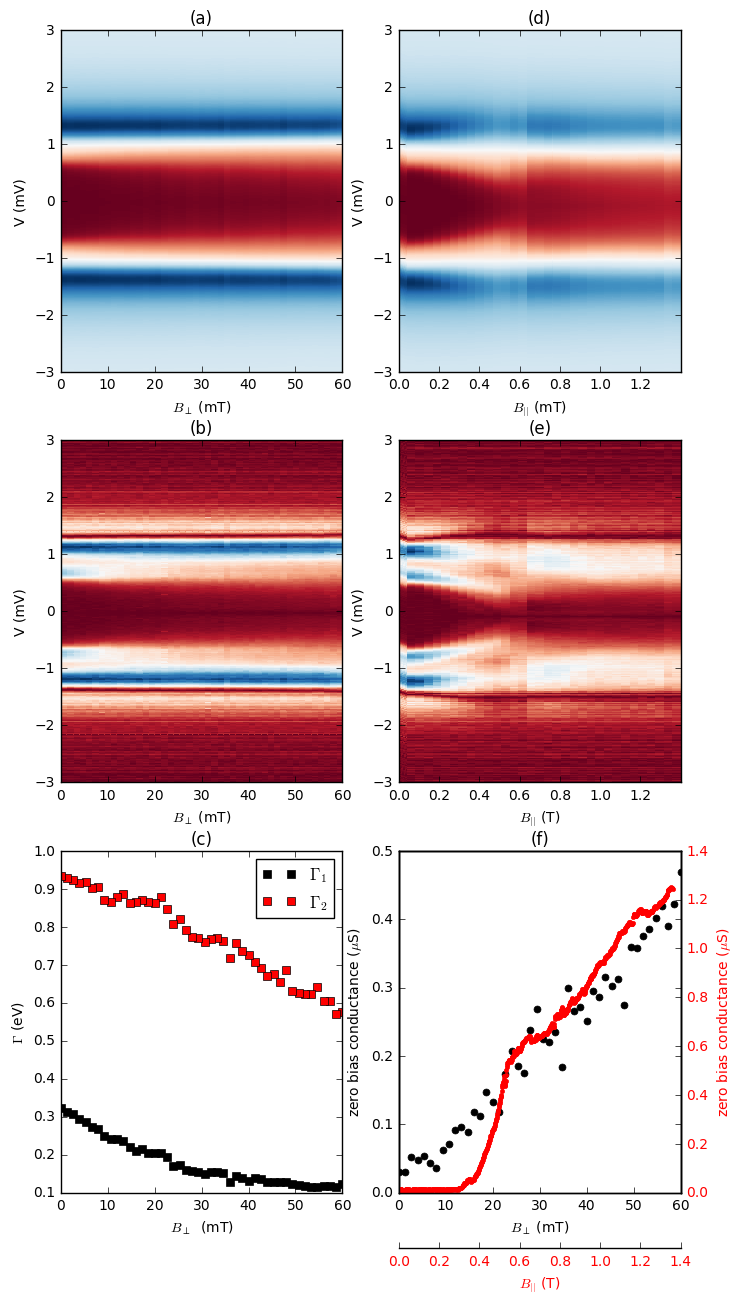

In [9]:
f , axarr = plt.subplots(3,2) #,gridspec_kw = {'width_ratios':[2, 1]})
f.set_size_inches(8, 15)

axarr[0,0].pcolor(Bs_perp,Vs_perp,Gs_perp,cmap = 'RdBu')
axarr[0,0].set_ylim([-3,3])
axarr[0,0].set_xlabel('$B_\perp$ (mT)')
axarr[0,0].set_ylabel('V (mV)')
axarr[0,0].set_title('(a)')

axarr[1,0].pcolor((Bs_perp[:][0:46].transpose())[:][0:Vs_perp.shape[1]-1],\
           (Vs_perp[:][0:46].transpose())[:][0:Vs_perp.shape[1]-1],\
           abs((dGdVs_perp[:][0:46].transpose())[:][0:Vs_perp.shape[1]-1]),cmap='RdBu')
axarr[1,0].set_ylim([-3,3])
axarr[1,0].set_xlabel('$B_\perp$ (mT)')
axarr[1,0].set_ylabel('V (mV)')
axarr[1,0].set_title('(b)')


axarr[0,1].pcolor(Bs_par,Vs_par,Gs_par,cmap = 'RdBu')
axarr[0,1].set_ylim([-3,3])
axarr[0,1].set_xlim([0,1.4])
axarr[0,1].set_xlabel('$B_{||}$ (mT)')
axarr[0,1].set_ylabel('V (mV)')
axarr[0,1].set_title('(d)')


axarr[1,1].pcolor((Bs_par.transpose())[:][0:Vs_par.shape[1]-1],\
           (Vs_par.transpose())[:][0:Vs_par.shape[1]-1],\
           abs(dGdVs_par.transpose()),\
          cmap='RdBu')
axarr[1,1].set_ylim([-3,3])
axarr[1,1].set_xlim([0,1.4])
axarr[1,1].set_xlabel('$B_{||}$ (T)')
axarr[1,1].set_ylabel('V (mV)')
axarr[1,1].set_title('(e)')




axarr[2,0].plot(PerB,(numpy.flipud(PerFieldData).transpose())[2],color = 'black',label = '$\Gamma_1$',marker = 's',\
             markersize = 6,linewidth = 0)
axarr[2,0].plot(PerB,(numpy.flipud(PerFieldData).transpose())[3],color = 'red',label = '$\Gamma_2$',marker = 's',\
             markersize = 6,linewidth = 0)
axarr[2,0].set_xlabel('$B_\perp$  (mT)') 
axarr[2,0].set_ylabel('$\Gamma$ (eV)')
axarr[2,0].legend()
axarr[2,0].set_title('(c)')



bigdata = scipy.io.loadmat('summary-data.mat')
G0 = bigdata['CondPerpField'][0][0][0][0][0][0]
axarr[2,1].set_xlabel('$B_\perp$ (mT)')
axarr[2,1].set_ylabel('zero bias conductance ($\mu$S)')
axarr[2,1].plot(PerB,G0,color = 'black',linewidth = 0,marker = '.',markersize = 10)
axarr[2,1].set_title('(f)')


bigdata = scipy.io.loadmat('summary-data.mat')
data = bigdata['CondParField'][0][0][0][0][0][0].transpose()
B = data[1]
G0 = data[2]
axtemp2 = axarr[2,1].twiny()
axtemp2.set_xlabel('$B_{||}$ (T)')
axtemp2.set_xlim([0,1.4])
for tl in axtemp2.get_xticklabels():
    tl.set_color('r')
axtemp2.xaxis.label.set_color('red')
axtemp2.tick_params(axis='x', labelcolor='red')

axtemp2.xaxis.set_ticks_position('bottom')
axtemp2.xaxis.set_label_position('bottom')
axtemp2.spines['bottom'].set_position(('outward', 40))


axtemp = axtemp2.twinx()
axtemp.plot(B[0:800],G0[0:800],color = 'red',linewidth = 0,marker = '.')

axtemp.yaxis.label.set_color('red')
axtemp.tick_params(axis='y', labelcolor='red')
temp = axtemp.set_ylabel('zero bias conductance ($\mu$S)')



## Figure 3 - Subgap signal

$\bf{(a,c)}$ Zoom in on the subgap signal in the conductance curves, as a function of increasing fields. $\bf{(a)}$: Perpendicular field, $\bf{(b)}$: Parallel field. In both case the curves were fitted using the equation:
$$ G(V,B) = N_0(B) + \alpha |V - V_0 | + \beta (V - V_0 )^2 $$
The fits were done between -0.3 and 0.3 mV

$\bf{(b,d)}$ The dependence of the fitting parameters of the magnetic field. There is clear linear and monotonic behavior in the perpendicular case. In the case of the parallel field, the monotonic behavior is apparent separately before and after the phase transition.ע
The parameters are all given in units of mili normalized conductance times voltage. Thats is done by integrating each component, so $\tilde{N_0} =10^3 \int dV N_0 $, $\tilde{\alpha} =10^3 \int dV \alpha |V - V_0| $ and $\tilde{\beta} =10^3\int dV \beta (V - V_0)^2 $. 

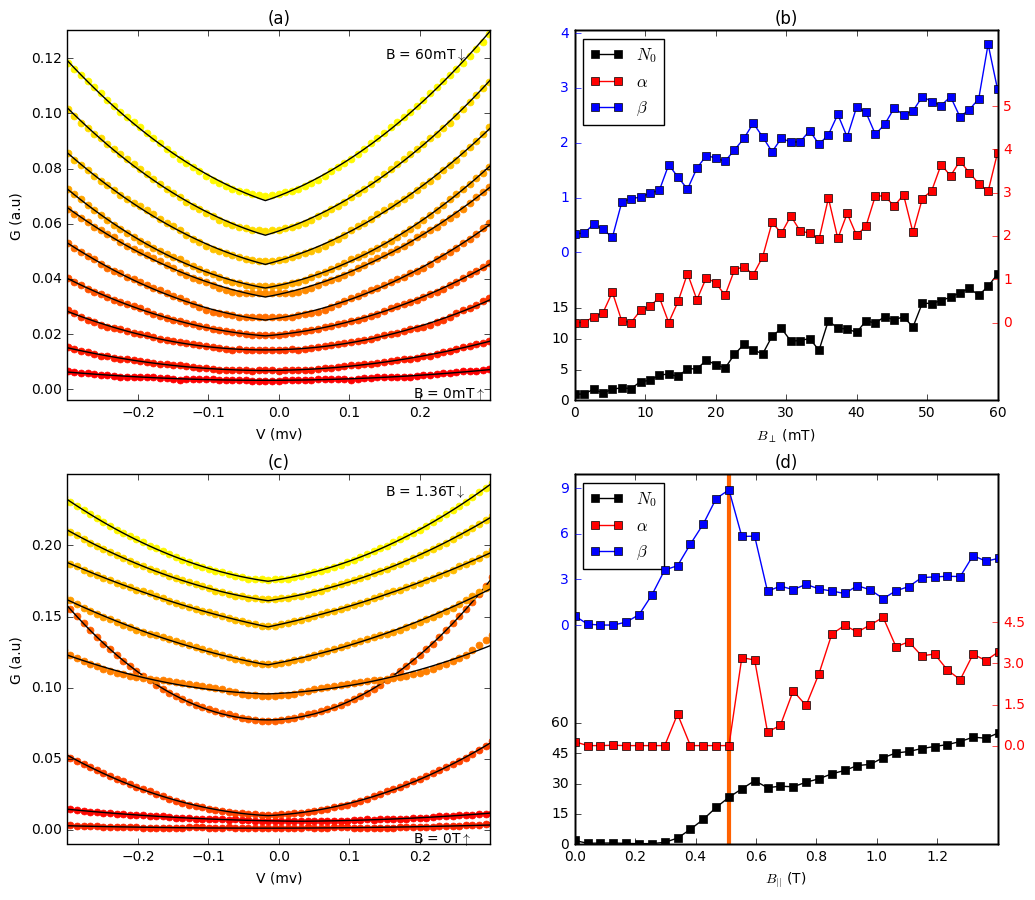

In [96]:
f , axarr = plt.subplots(2,2)
f.set_size_inches(12, 10.5)
axarr[0,0].set_title('(a)')
axarr[0,1].set_title('(b)')
axarr[1,0].set_title('(c)')
axarr[1,1].set_title('(d)')

# con = ConnectionPatch(xyA=(0.51,0.3), xyB=(0.5,0.08), coordsA='data', coordsB='data',
#                       axesA=axarr[1,1], axesB=axarr[1,0],
#                       arrowstyle="->")
# axarr[1,1].add_artist(con)

for k in range(46,0,-5):
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    MinIndex = numpy.argmin(abs(V+0.4))
    MaxIndex = numpy.argmin(abs(V-0.4))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    a = PerFieldLinFit_0p3[k-1][0]
    b = PerFieldLinFit_0p3[k-1][1]
    c = PerFieldLinFit_0p3[k-1][2]
    V0 = PerFieldLinFit_0p3[k-1][3]
    axarr[0,0].plot(V,G,marker = '.',linewidth = 0,markersize = 10,color = plt.cm.autumn((46-k)/46))
    axarr[0,0].plot(V,a*(V-V0)**2+b*abs((V-V0))+c,color = 'black',linewidth = 1)
axarr[0,0].set_xlim([-0.3,0.3])
axarr[0,0].set_ylim([-0.004,0.13])
axarr[0,0].set_xlabel('V (mv)')
axarr[0,0].set_ylabel('G (a.u)')
axarr[0,0].annotate('B = 0mT$\\uparrow$',xy = (0.19,-0.003))
axarr[0,0].annotate('B = 60mT$\downarrow$',xy = (0.15,0.12))


for k in range(1,34,4):
    V, G, Gasym, B = LoadandSymmetrizeParField(k,0.025)
    MinIndex = numpy.argmin(abs(V+0.4))
    MaxIndex = numpy.argmin(abs(V-0.4))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    a = ParFieldLinFit_0p3[k-1][0]
    b = ParFieldLinFit_0p3[k-1][1]
    c = ParFieldLinFit_0p3[k-1][2]
    V0 = ParFieldLinFit_0p3[k-1][3]
    axarr[1,0].plot(V,G,marker = '.',linewidth = 0,markersize = 10,color = plt.cm.autumn(k/34))
    axarr[1,0].plot(V,a*(V-V0)**2+b*abs((V-V0))+c,color = 'black',linewidth = 1)
axarr[1,0].set_xlim([-0.3,0.3])
axarr[1,0].set_ylim([-0.01,0.25])
axarr[1,0].set_xlabel('V (mv)')
axarr[1,0].set_ylabel('G (a.u)')
axarr[1,0].annotate('B = 0T$\\uparrow$',xy = (0.19,-0.009))
axarr[1,0].annotate('B = 1.36T$\downarrow$',xy = (0.15,0.235))


lns1 = axarr[0,1].plot(PerB,1e3*0.3*(PerFieldLinFit_0p3.transpose())[2],color = 'black',label = '$N_0$',marker = 's',\
             markersize = 6,linewidth = 1)
axt = axarr[0,1].twinx()
lns2 = axt.plot(PerB,1e3*0.045*(PerFieldLinFit_0p3.transpose())[1],color = 'red',label = '$\\alpha$',marker = 's',\
             markersize = 6,linewidth = 1)
axt2 = axarr[0,1].twinx()
lns3 = axt2.plot(PerB,1e3*0.009*(PerFieldLinFit_0p3.transpose())[0],color = 'blue',label = '$\\beta$',marker = 's',\
             markersize = 6,linewidth = 1)
axt.tick_params(axis='y', colors='red')
axt2.tick_params(axis='y', colors='blue')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
axarr[0,1].legend(lns, labs, loc=2)

axarr[0,1].set_xlabel('$B_\perp$ (mT)')

axarr[0,1].set_ylim([0,1e3*0.2*0.3])
axt.set_ylim([-1e3*0.045*0.04,1e3*0.045*0.15])
axt2.set_ylim([-1e3*0.009*0.3,1e3*0.009*0.45])

axarr[0,1].yaxis.set_ticks([0,5,10,15])
axt.yaxis.set_ticks([0,1,2,3,4,5])

axt2.yaxis.set_ticks([0,1,2,3,4])
axt2.yaxis.set_ticks_position('left')




axarr[1,1].set_xlabel('$B_{||}$ (T)')
axarr[1,1].plot([0.51,0.51],[0,300],color = plt.cm.autumn(13/34),linewidth = 3)
lns1 = axarr[1,1].plot(ParB,1e3*0.3*(ParFieldLinFit_0p3.transpose())[2],color = 'black',label = '$N_0$',marker = 's',\
             markersize = 6,linewidth = 1)
axt = axarr[1,1].twinx()
lns2 = axt.plot(ParB,1e3*0.045*(ParFieldLinFit_0p3.transpose())[1],color = 'red',label = '$\\alpha$',marker = 's',\
             markersize = 6,linewidth = 1)
axt2 = axarr[1,1].twinx()
lns3 = axt2.plot(ParB,1e3*0.009*(ParFieldLinFit_0p3.transpose())[0],color = 'blue',label = '$\\beta$',marker = 's',\
             markersize = 6,linewidth = 1)
axt.tick_params(axis='y', colors='red')
axt2.tick_params(axis='y', colors='blue')
axarr[1,1].set_xlim([0,1.4])

axarr[1,1].set_ylim([0,1e3*0.3*0.61])
axt.set_ylim([-1e3*0.045*0.08,1e3*0.045*0.22])
axt2.set_ylim([-1e3*0.009*1.6,1e3*0.009*1.1])

axarr[1,1].yaxis.set_ticks([0,15,30,45,60])
axt.yaxis.set_ticks([0,1.5,3,4.5])
axt2.yaxis.set_ticks([0,3,6,9])
axt2.yaxis.set_ticks_position('left')


lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
temp = axarr[1,1].legend(lns, labs, loc=2)


## Supplementary figures


#### S1 - Fitted temperature Vs. sample temperature

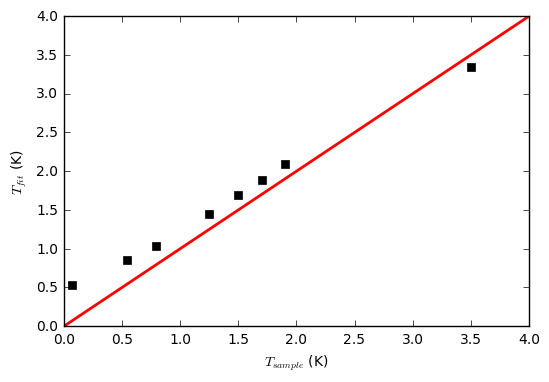

In [11]:
T = Tempdata.transpose()[6]/0.08
Delta01 = Tempdata.transpose()[0]
Delta02 = Tempdata.transpose()[1]


plt.plot(Tsample,T,color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.plot([0,4],[0,4],'red',linewidth = 2)
plt.xlabel('$T_{sample}$ (K)')
plt.ylabel('$T_{fit}$ (K)')
plt.show()


#### S2 - Comparison between finite and zero $\Delta_2$
Two fits are compared: (a) fitting using fixed $\Delta_2 = 0$, (b) $\Delta_2$ is a free parameter. Though (b) gives a better fit, we cannot rule out completely (a)

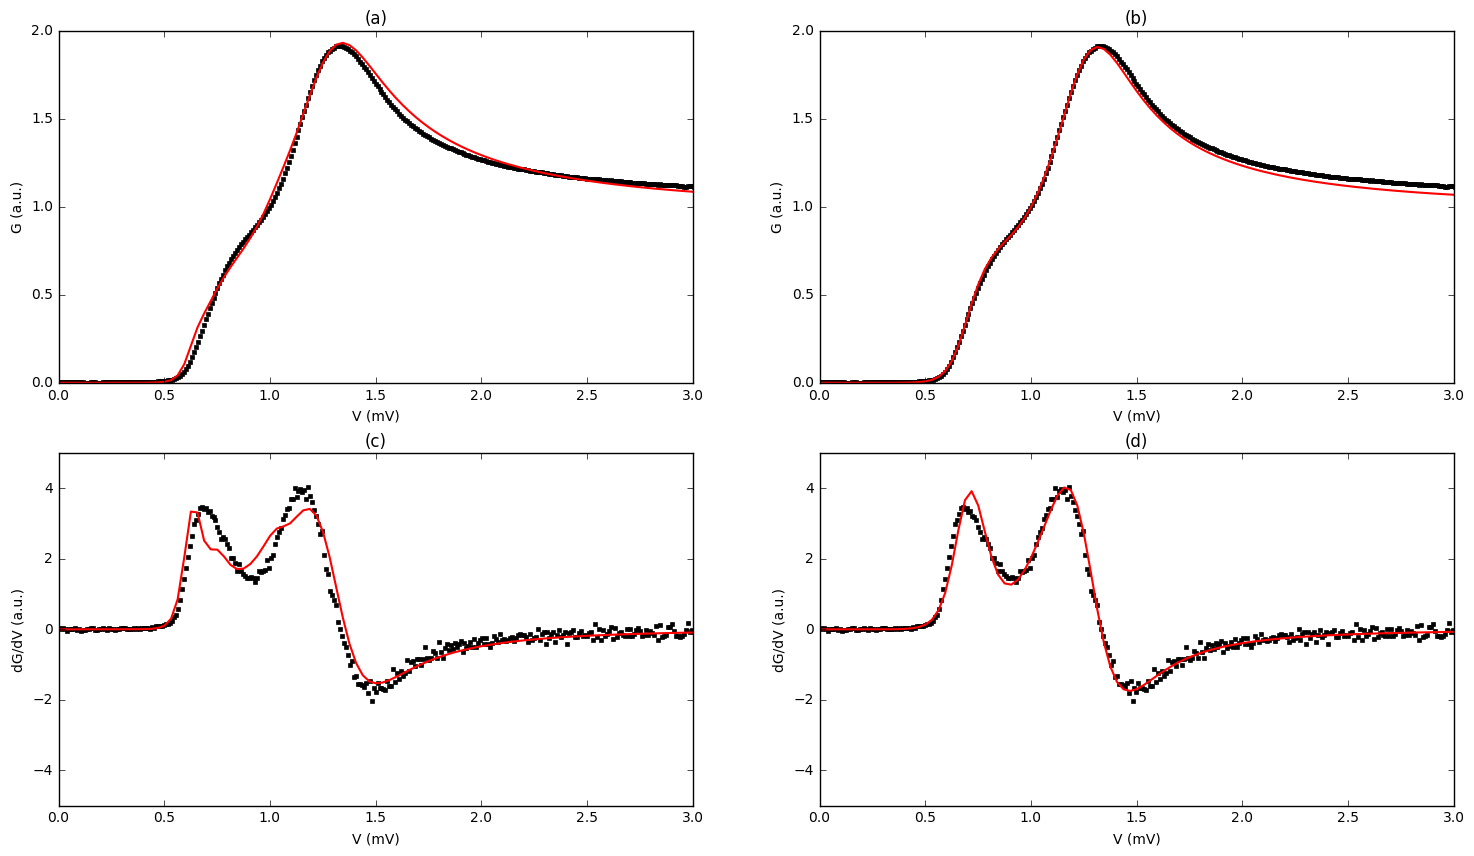

In [12]:
V, G, Gasym = LoadandSymmetrizeTemp(1,0.125)



f , axarr = plt.subplots(2,2)
f.set_size_inches(18, 10)
axarr[0,0].set_title('(a)')
axarr[0,1].set_title('(b)')
axarr[1,0].set_title('(c)')
axarr[1,1].set_title('(d)')

LoadFitPlotG(axarr[0,0],V,G,makeParamaters(FitNoDelta2),[0,3],False)
LoadFitPlotG(axarr[0,1],V,G,makeParamaters(Tempdata[0]),[0,3],False)
LoadFitPlotdGdV(axarr[1,0],V,G,makeParamaters(FitNoDelta2),[0,3])
LoadFitPlotdGdV(axarr[1,1],V,G,makeParamaters(Tempdata[0]),[0,3])



#### S3 - Comparison between different fits to the field dependent data

Three fitting schemes are compared: 
(a,b) fitting using fixed $\Delta_1$ and $\Delta_2$, where $\Gamma_1$ and $\Gamma_2$ are free fitting parameters.
(c,d) $\Delta_1$, $\Delta_2$, $\Gamma_1$, and $\Gamma_2$ are free fitting parameters. 
(e,f) fitting using fixed $\Gamma_1$ and $\Gamma_2$, where $\Delta_1$ and $\Delta_2$ are free fitting parameters.

While the first two options give reasonable fits, the third one cannot give a good fit.

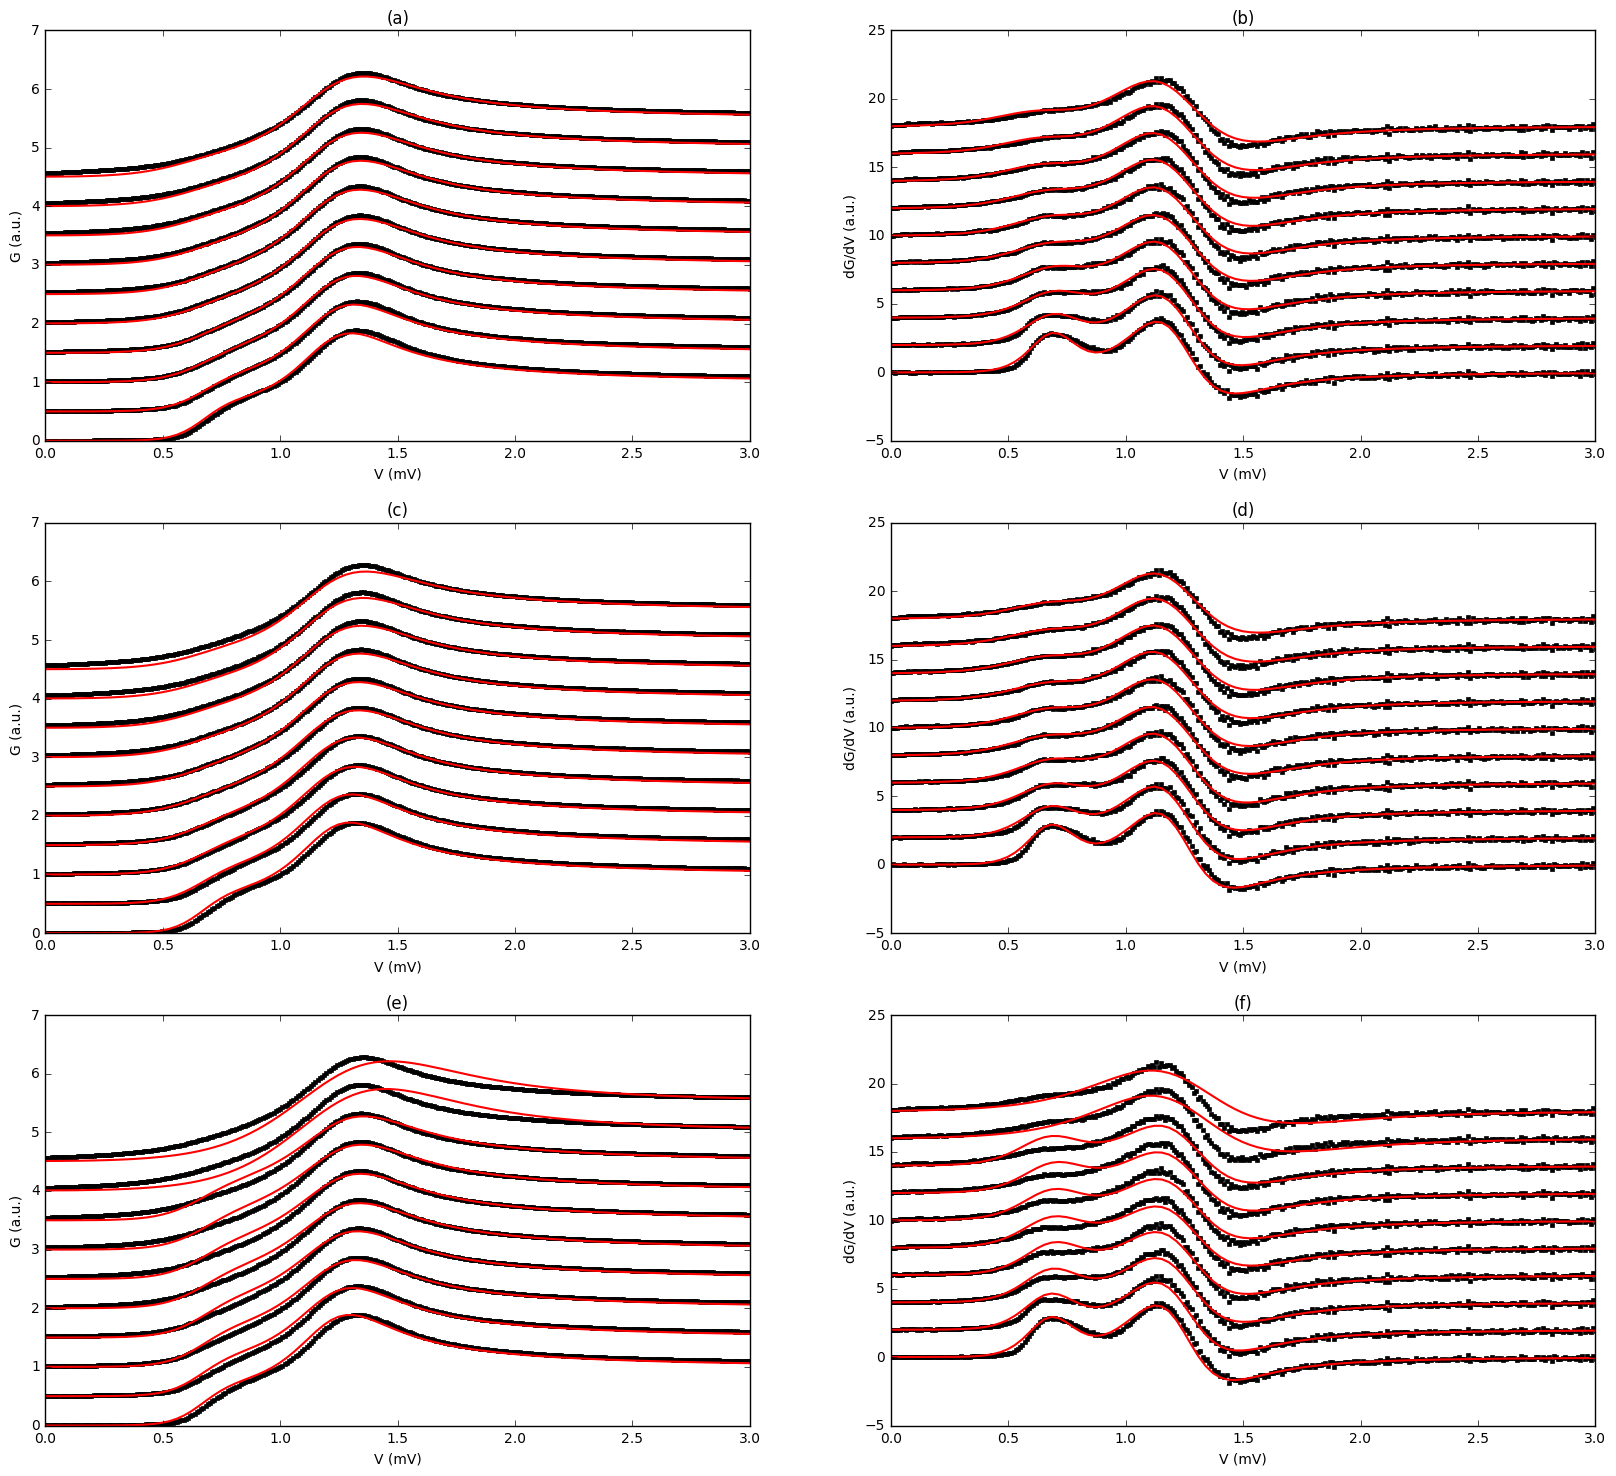

In [13]:
f , axarr = plt.subplots(3,2 )
f.set_size_inches(20, 18)

axarr[0,0].set_title('(a)')
axarr[0,1].set_title('(b)')
axarr[1,0].set_title('(c)')
axarr[1,1].set_title('(d)')
axarr[2,0].set_title('(e)')
axarr[2,1].set_title('(f)')



for k in range(46,0,-5):
    V, G, Gasym= LoadandSymmetrizePerField(k,-0.035)
    LoadFitPlotG(axarr[0,0],V,G,makeParamaters(PerFieldData[46-k]),[0,3],False,(46-k)*0.1)
    LoadFitPlotG(axarr[1,0],V,G,makeParamaters(PerFieldDataFreeDeltas[46-k]),[0,3],False,(46-k)*0.1)
    LoadFitPlotG(axarr[2,0],V,G,makeParamaters(PerFieldDataFixedGammas[46-k]),[0,3],False,(46-k)*0.1)

    
for k in range(46,0,-5):
    V, G, Gasym= LoadandSymmetrizePerField(k,-0.035)
    LoadFitPlotdGdV(axarr[0,1],V,G,makeParamaters(PerFieldData[46-k]),[0,3],(46-k)*0.4)
    LoadFitPlotdGdV(axarr[1,1],V,G,makeParamaters(PerFieldDataFreeDeltas[46-k]),[0,3],(46-k)*0.4)
    LoadFitPlotdGdV(axarr[2,1],V,G,makeParamaters(PerFieldDataFixedGammas[46-k]),[0,3],(46-k)*0.4)




#### S4 - McMillen model parameters as a function field

The McMillen model parameters resulting from the fits discussed in S3 are shown. In (a) the first fitting scheme was used, and in (b) the second fitting scheme. Having $\Delta_2$ increase with magnetic field is unreasonable, therefore we can trust better the first fitting scheme. In any scheme we choose, the interband tunneling rates decrease.

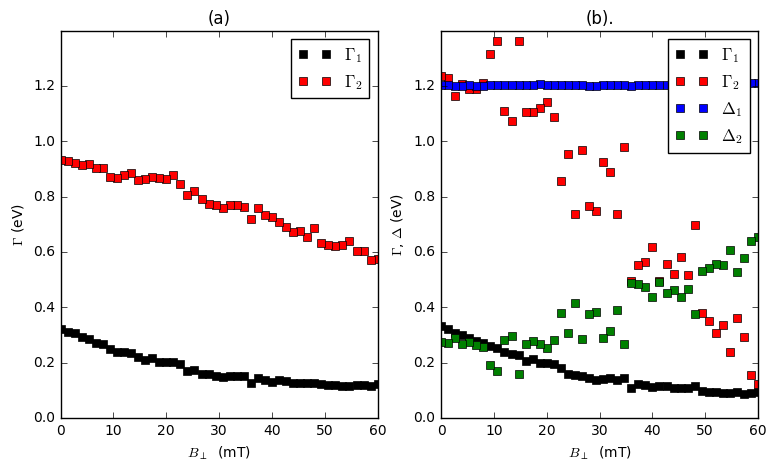

In [14]:
f , axarr = plt.subplots(1,2)
f.set_size_inches(9, 5)

axarr[0].plot(PerB,(numpy.flipud(PerFieldData).transpose())[2],color = 'black',label = '$\Gamma_1$',marker = 's',\
             markersize = 6,linewidth = 0)
axarr[0].plot(PerB,(numpy.flipud(PerFieldData).transpose())[3],color = 'red',label = '$\Gamma_2$',marker = 's',\
             markersize = 6,linewidth = 0)
axarr[0].set_xlabel('$B_\perp$  (mT)') 
axarr[0].set_ylabel('$\Gamma$ (eV)')
axarr[0].legend()
axarr[0].set_title('(a)')
axarr[0].set_ylim([0,1.4])


axarr[1].plot(PerB,(numpy.flipud(PerFieldDataFreeDeltas).transpose())[2],color = 'black',label = '$\Gamma_1$',marker = 's',\
             markersize = 6,linewidth = 0)
axarr[1].plot(PerB,(numpy.flipud(PerFieldDataFreeDeltas).transpose())[3],color = 'red',label = '$\Gamma_2$',marker = 's',\
             markersize = 6,linewidth = 0)
axarr[1].plot(PerB,(numpy.flipud(PerFieldDataFreeDeltas).transpose())[0],color = 'blue',label = '$\Delta_1$',marker = 's',\
             markersize = 6,linewidth = 0)
axarr[1].plot(PerB,(numpy.flipud(PerFieldDataFreeDeltas).transpose())[1],color = 'green',label = '$\Delta_2$',marker = 's',\
             markersize = 6,linewidth = 0)


axarr[1].set_xlabel('$B_\perp$  (mT)') 
axarr[1].set_ylabel('$\Gamma$, $\Delta$ (eV)')
axarr[1].set_title('(b).')
axarr[1].set_ylim([0,1.4])
temp = axarr[1].legend()



#### S5 - log scale of the low temperature, zero field conductance curve

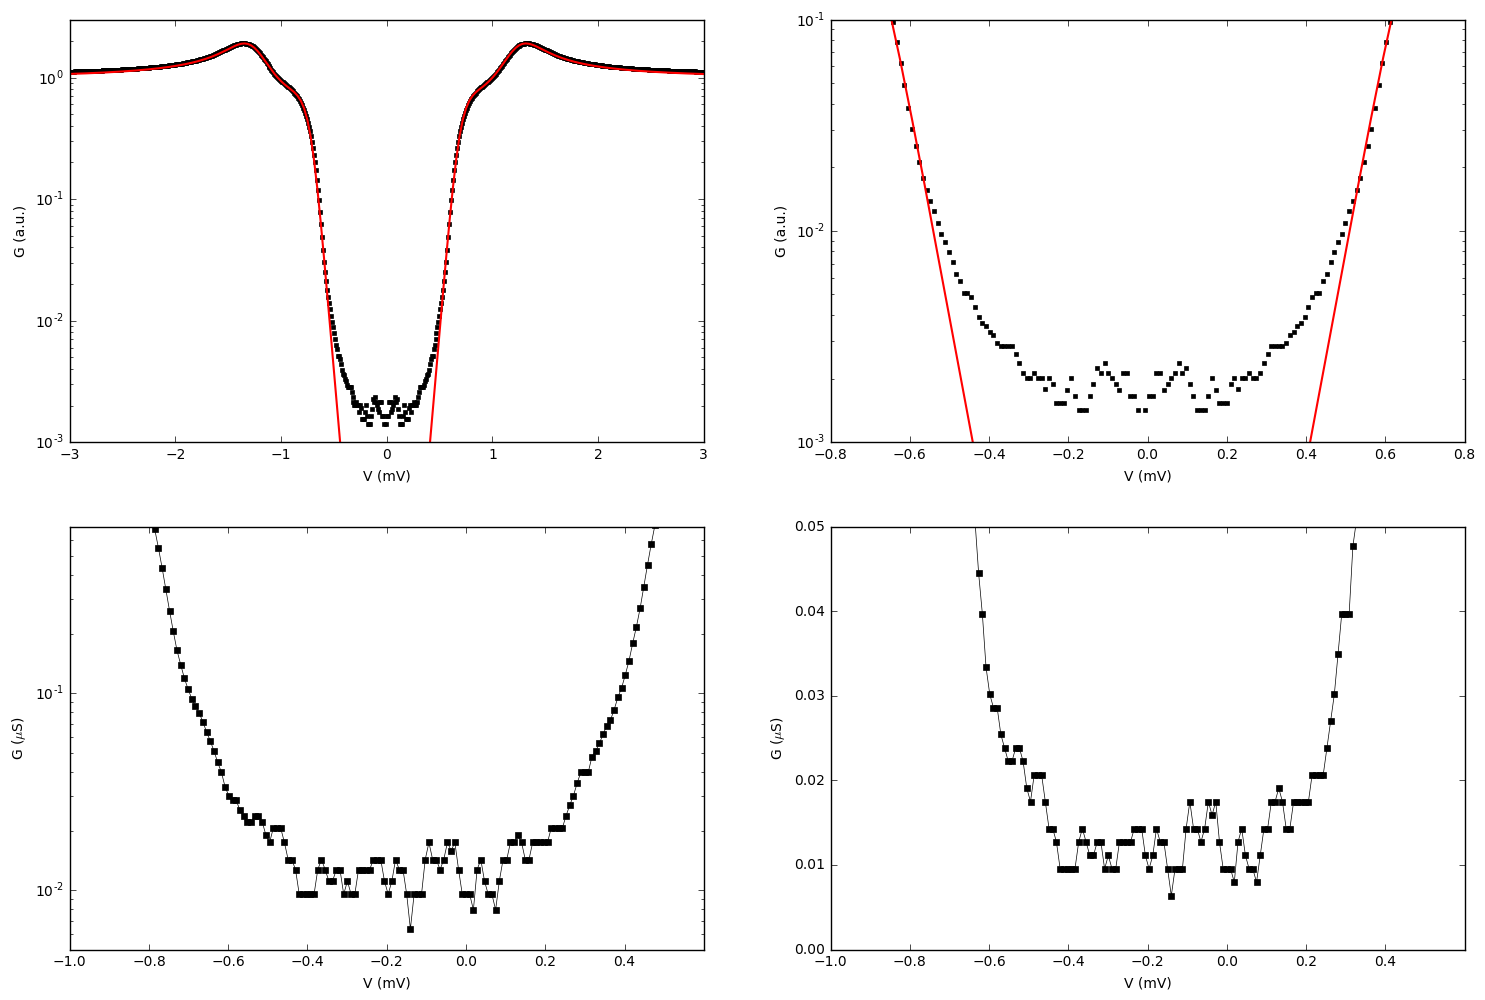

In [15]:
f , axarr = plt.subplots(2,2)
f.set_size_inches(18, 12)
V, G, Gasym = LoadandSymmetrizeTemp(1,0.125)



LoadFitPlotG(axarr[0,0],V,G,makeParamaters(Tempdata[0]),[-3,3],False)
axarr[0,0].set_yscale('log')
axarr[0,0].set_ylim([1e-3,3])
# axarr.set_xlim([-1,1])

LoadFitPlotG(axarr[0,1],V,G,makeParamaters(Tempdata[0]),[-3,3],False)
axarr[0,1].set_ylim([1e-3,0.1])
axarr[0,1].set_xlim([-0.8,0.8])
axarr[0,1].set_yscale('log')


bigdata = scipy.io.loadmat('summary-data.mat')
tempdata = bigdata['Temperature']    
data = numpy.array(tempdata[0][0][1][0][0][0]).transpose()
V = data[1]
G = data[2]
    
axarr[1,0].plot(V,G,marker = 's',color = 'black',markersize = 5,linewidth = 0.5)
axarr[1,0].set_yscale('log')
axarr[1,0].set_ylim([5e-3,0.7])
axarr[1,0].set_xlim([-1,0.6])
axarr[1,0].set_xlabel('V (mV)')
axarr[1,0].set_ylabel('G ($\mu$S)')

axarr[1,1].plot(V,G,marker = 's',color = 'black',markersize = 5,linewidth = 0.5)
axarr[1,1].set_ylim([0,0.05])
axarr[1,1].set_xlim([-1,0.6])
axarr[1,1].set_xlabel('V (mV)')
temp = axarr[1,1].set_ylabel('G ($\mu$S)')

#### S6 -  Conductance curves at low bias are decomposed to the constant, linear and parabolic part at several fields.

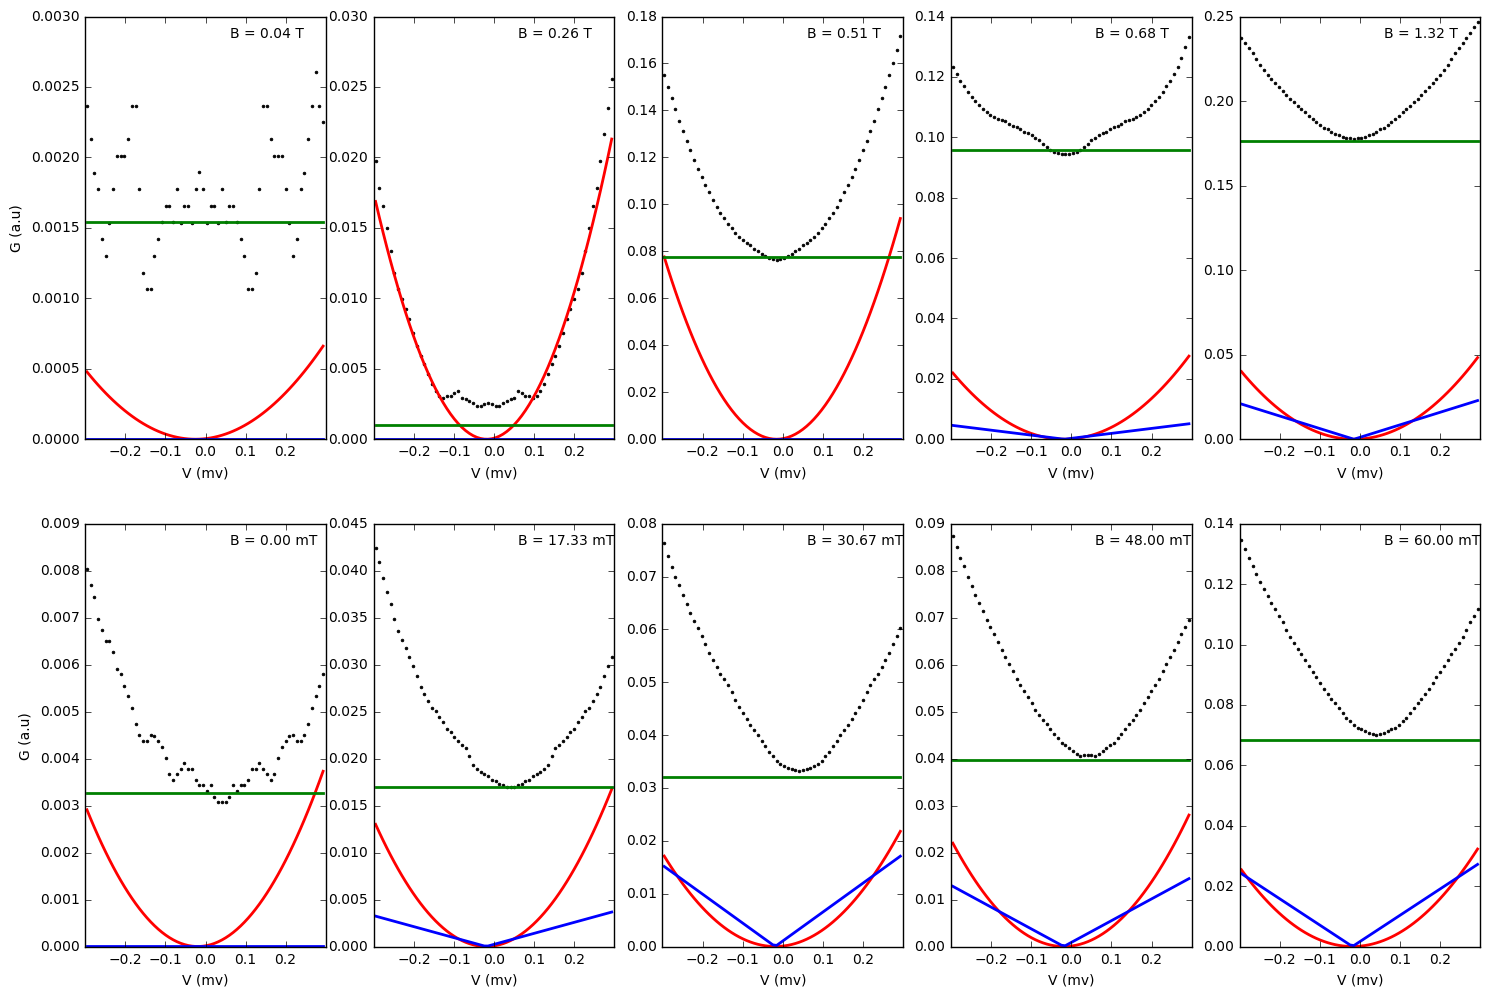

In [93]:
f , axarr = plt.subplots(2,5)
f.set_size_inches(18, 12)


ks = [2,7,13,17,32]
for j in range(len(ks)):
    k = ks[j]
    V, G, Gasym, B = LoadandSymmetrizeParField(k,0.025)
    MinIndex = numpy.argmin(abs(V+0.3))
    MaxIndex = numpy.argmin(abs(V-0.3))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    a = ParFieldLinFit_0p3[k-1][0]
    b = ParFieldLinFit_0p3[k-1][1]
    c = ParFieldLinFit_0p3[k-1][2]
    V0 = ParFieldLinFit_0p3[k-1][3]
    axarr[0,j].plot(V,G,marker = '.',linewidth = 0,markersize = 4,color = 'black')
    axarr[0,j].plot(V,a*(V-V0)**2,color = 'red',linewidth = 2)
    axarr[0,j].plot(V,b*abs((V-V0)),color = 'blue',linewidth = 2)
    axarr[0,j].plot(V,V*0+c,color = 'green',linewidth = 2)
    axarr[0,j].set_xlim([-0.3,0.3])
    # axarr.set_ylim([-0.01,0.25])
    axarr[0,j].set_xlabel('V (mv)')
    axarr[0,j].annotate('B = '+str(format(ParB[k-1], '0.2f'))+' T',xy = (0.6,0.95),xycoords = 'axes fraction')

axarr[0,0].set_ylabel('G (a.u)')


ks = [46,33,23,10,1]

for j in range(len(ks)):
    k = ks[j]
    V, G, Gasym = LoadandSymmetrizePerField(k,0.025)
    MinIndex = numpy.argmin(abs(V+0.3))
    MaxIndex = numpy.argmin(abs(V-0.3))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    a = PerFieldLinFit_0p3[k-1][0]
    b = PerFieldLinFit_0p3[k-1][1]
    c = PerFieldLinFit_0p3[k-1][2]
    V0 = PerFieldLinFit_0p3[k-1][3]
    axarr[1,j].plot(V,G,marker = '.',linewidth = 0,markersize = 4,color = 'black')
    axarr[1,j].plot(V,a*(V-V0)**2,color = 'red',linewidth = 2)
    axarr[1,j].plot(V,b*abs((V-V0)),color = 'blue',linewidth = 2)
    axarr[1,j].plot(V,V*0+c,color = 'green',linewidth = 2)
    axarr[1,j].set_xlim([-0.3,0.3])
    # axarr.set_ylim([-0.01,0.25])
    axarr[1,j].set_xlabel('V (mv)')
    axarr[1,j].annotate('B = '+str(format(PerB[k-1], '0.2f'))+' mT',xy = (0.6,0.95),xycoords = 'axes fraction')

axarr[1,0].set_ylabel('G (a.u)')

#### S2 - Comparison between T = 200 mK and T = 540 mK
Two fits are compared: (a) fitting using fixed T = 200mK, (b) T is a free parameter. (b) fits the data better.

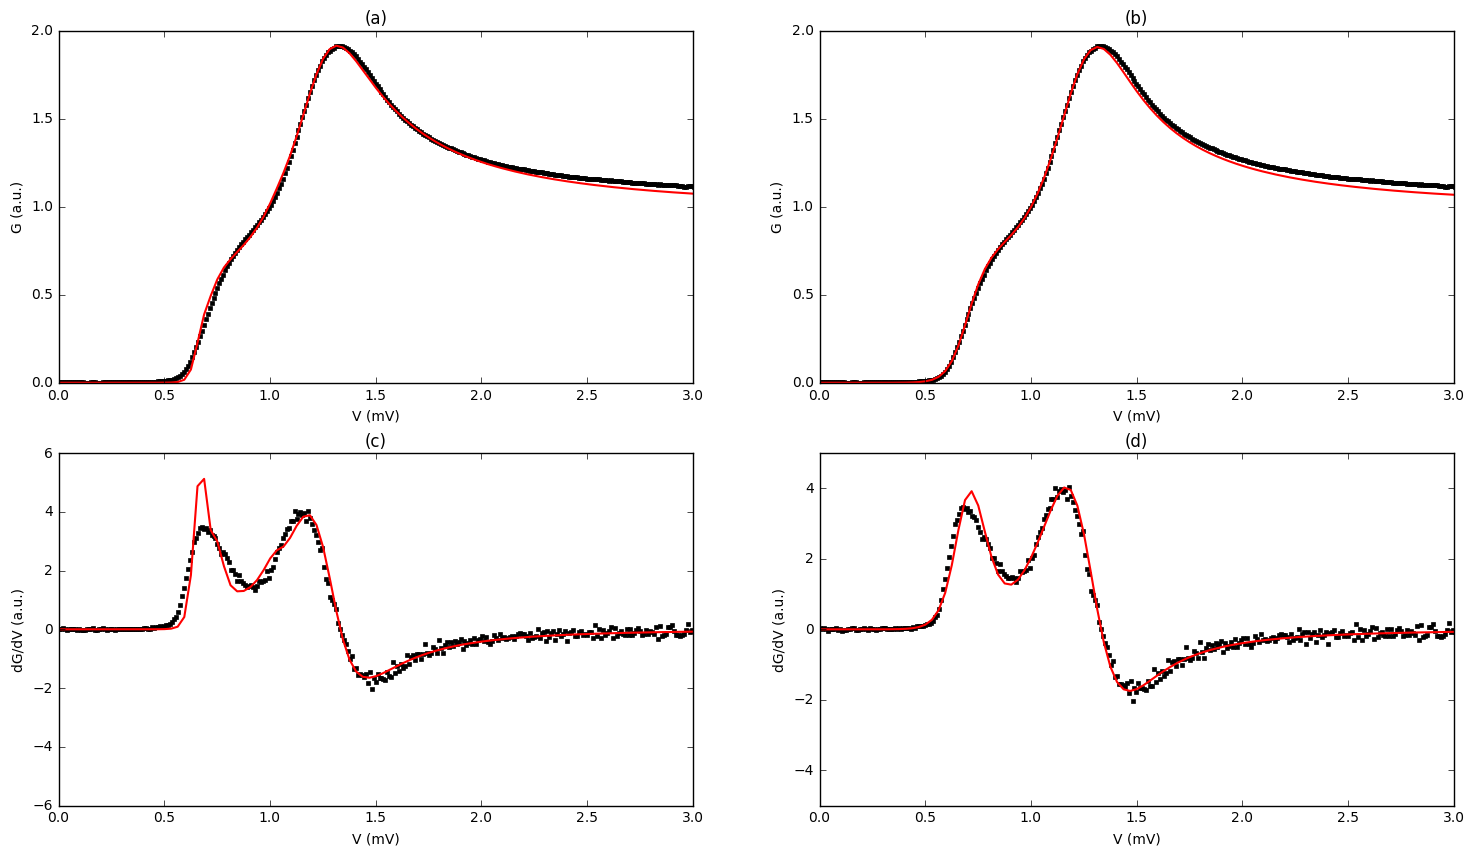

In [89]:
V, G, Gasym = LoadandSymmetrizeTemp(1,0.125)



f , axarr = plt.subplots(2,2)
f.set_size_inches(18, 10)
axarr[0,0].set_title('(a)')
axarr[0,1].set_title('(b)')
axarr[1,0].set_title('(c)')
axarr[1,1].set_title('(d)')

LoadFitPlotG(axarr[0,0],V,G,makeParamaters(FitFixedT200mK),[0,3],False)
LoadFitPlotG(axarr[0,1],V,G,makeParamaters(Tempdata[0]),[0,3],False)
LoadFitPlotdGdV(axarr[1,0],V,G,makeParamaters(FitFixedT200mK),[0,3])
LoadFitPlotdGdV(axarr[1,1],V,G,makeParamaters(Tempdata[0]),[0,3])

#### S8 - comparison of the V shape fits where the were done as in figure 3, but between -0.2 and 0.2 mV (upper panels) and -0.1 and 0.1 mV (lower panels).

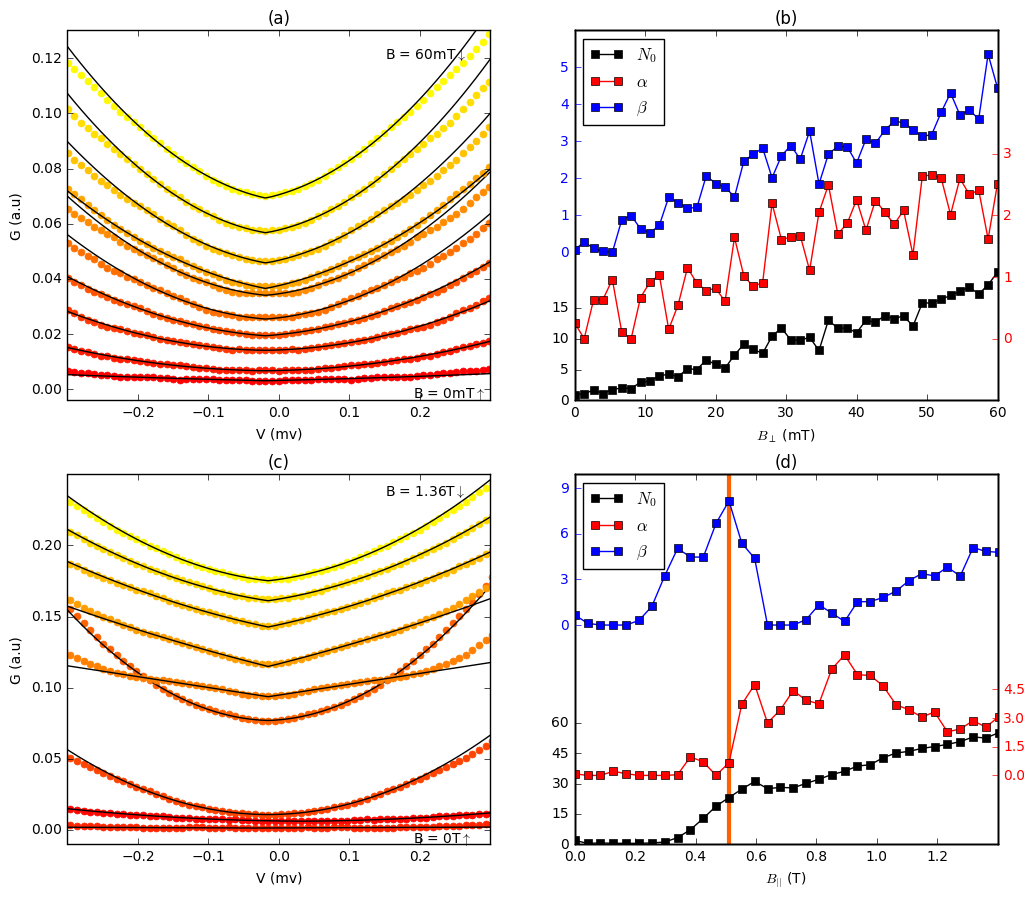

In [108]:
f , axarr = plt.subplots(2,2)
f.set_size_inches(12, 10.5)
axarr[0,0].set_title('(a)')
axarr[0,1].set_title('(b)')
axarr[1,0].set_title('(c)')
axarr[1,1].set_title('(d)')

# con = ConnectionPatch(xyA=(0.51,0.3), xyB=(0.5,0.08), coordsA='data', coordsB='data',
#                       axesA=axarr[1,1], axesB=axarr[1,0],
#                       arrowstyle="->")
# axarr[1,1].add_artist(con)

for k in range(46,0,-5):
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    MinIndex = numpy.argmin(abs(V+0.4))
    MaxIndex = numpy.argmin(abs(V-0.4))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    a = PerFieldLinFit_0p2[k-1][0]
    b = PerFieldLinFit_0p2[k-1][1]
    c = PerFieldLinFit_0p2[k-1][2]
    V0 = PerFieldLinFit_0p2[k-1][3]
    axarr[0,0].plot(V,G,marker = '.',linewidth = 0,markersize = 10,color = plt.cm.autumn((46-k)/46))
    axarr[0,0].plot(V,a*(V-V0)**2+b*abs((V-V0))+c,color = 'black',linewidth = 1)
axarr[0,0].set_xlim([-0.3,0.3])
axarr[0,0].set_ylim([-0.004,0.13])
axarr[0,0].set_xlabel('V (mv)')
axarr[0,0].set_ylabel('G (a.u)')
axarr[0,0].annotate('B = 0mT$\\uparrow$',xy = (0.19,-0.003))
axarr[0,0].annotate('B = 60mT$\downarrow$',xy = (0.15,0.12))


for k in range(1,34,4):
    V, G, Gasym, B = LoadandSymmetrizeParField(k,0.025)
    MinIndex = numpy.argmin(abs(V+0.4))
    MaxIndex = numpy.argmin(abs(V-0.4))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    a = ParFieldLinFit_0p2[k-1][0]
    b = ParFieldLinFit_0p2[k-1][1]
    c = ParFieldLinFit_0p2[k-1][2]
    V0 = ParFieldLinFit_0p2[k-1][3]
    axarr[1,0].plot(V,G,marker = '.',linewidth = 0,markersize = 10,color = plt.cm.autumn(k/34))
    axarr[1,0].plot(V,a*(V-V0)**2+b*abs((V-V0))+c,color = 'black',linewidth = 1)
axarr[1,0].set_xlim([-0.3,0.3])
axarr[1,0].set_ylim([-0.01,0.25])
axarr[1,0].set_xlabel('V (mv)')
axarr[1,0].set_ylabel('G (a.u)')
axarr[1,0].annotate('B = 0T$\\uparrow$',xy = (0.19,-0.009))
axarr[1,0].annotate('B = 1.36T$\downarrow$',xy = (0.15,0.235))


lns1 = axarr[0,1].plot(PerB,1e3*0.3*(PerFieldLinFit_0p2.transpose())[2],color = 'black',label = '$N_0$',marker = 's',\
             markersize = 6,linewidth = 1)
axt = axarr[0,1].twinx()
lns2 = axt.plot(PerB,1e3*0.045*(PerFieldLinFit_0p2.transpose())[1],color = 'red',label = '$\\alpha$',marker = 's',\
             markersize = 6,linewidth = 1)
axt2 = axarr[0,1].twinx()
lns3 = axt2.plot(PerB,1e3*0.009*(PerFieldLinFit_0p2.transpose())[0],color = 'blue',label = '$\\beta$',marker = 's',\
             markersize = 6,linewidth = 1)
axt.tick_params(axis='y', colors='red')
axt2.tick_params(axis='y', colors='blue')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
axarr[0,1].legend(lns, labs, loc=2)

axarr[0,1].set_xlabel('$B_\perp$ (mT)')

axarr[0,1].set_ylim([0,1e3*0.2*0.3])
axt.set_ylim([-1,5])
axt2.set_ylim([-4,6])

axarr[0,1].yaxis.set_ticks([0,5,10,15])
axt.yaxis.set_ticks([0,1,2,3])

axt2.yaxis.set_ticks([0,1,2,3,4,5])
axt2.yaxis.set_ticks_position('left')




axarr[1,1].set_xlabel('$B_{||}$ (T)')
axarr[1,1].plot([0.51,0.51],[0,300],color = plt.cm.autumn(13/34),linewidth = 3)
lns1 = axarr[1,1].plot(ParB,1e3*0.3*(ParFieldLinFit_0p2.transpose())[2],color = 'black',label = '$N_0$',marker = 's',\
             markersize = 6,linewidth = 1)
axt = axarr[1,1].twinx()
lns2 = axt.plot(ParB,1e3*0.045*(ParFieldLinFit_0p2.transpose())[1],color = 'red',label = '$\\alpha$',marker = 's',\
             markersize = 6,linewidth = 1)
axt2 = axarr[1,1].twinx()
lns3 = axt2.plot(ParB,1e3*0.009*(ParFieldLinFit_0p2.transpose())[0],color = 'blue',label = '$\\beta$',marker = 's',\
             markersize = 6,linewidth = 1)
axt.tick_params(axis='y', colors='red')
axt2.tick_params(axis='y', colors='blue')
axarr[1,1].set_xlim([0,1.4])

axarr[1,1].set_ylim([0,1e3*0.3*0.61])
axt.set_ylim([-1e3*0.045*0.08,1e3*0.045*0.35])
axt2.set_ylim([-1e3*0.009*1.6,1e3*0.009*1.1])

axarr[1,1].yaxis.set_ticks([0,15,30,45,60])
axt.yaxis.set_ticks([0,1.5,3,4.5])
axt2.yaxis.set_ticks([0,3,6,9])
axt2.yaxis.set_ticks_position('left')


lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
temp = axarr[1,1].legend(lns, labs, loc=2)


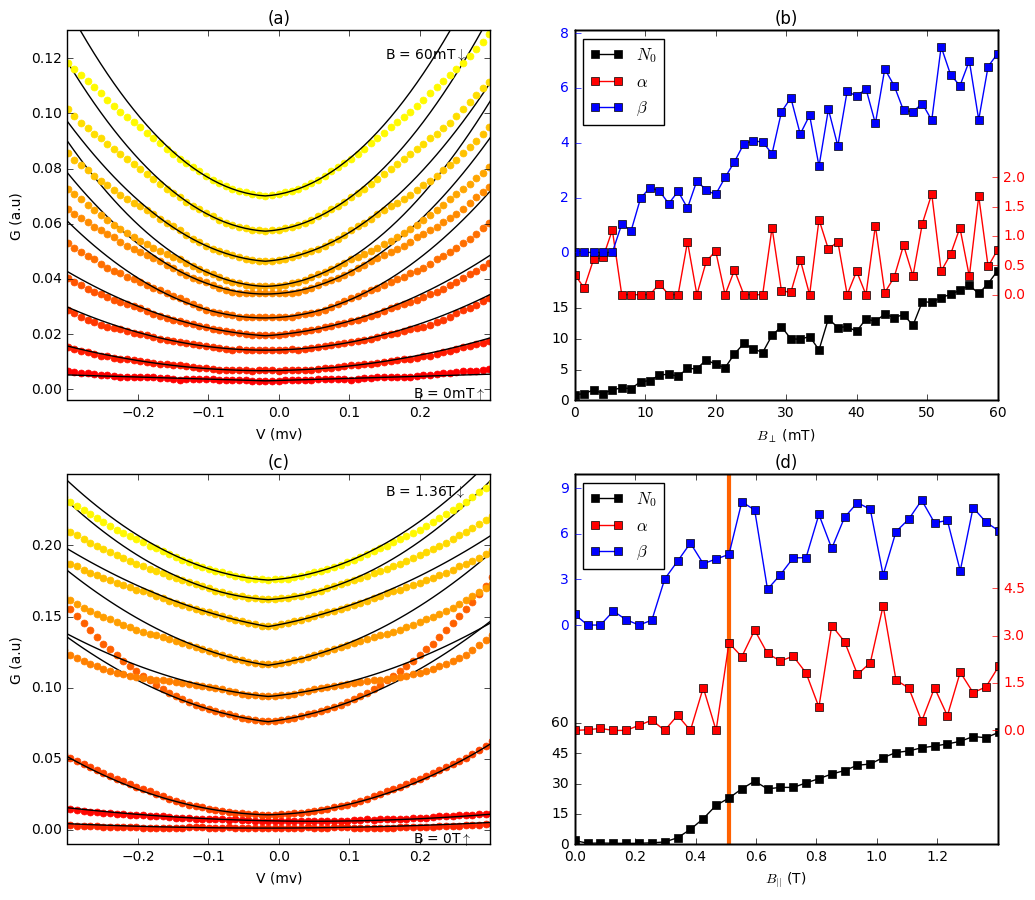

In [114]:
f , axarr = plt.subplots(2,2)
f.set_size_inches(12, 10.5)
axarr[0,0].set_title('(a)')
axarr[0,1].set_title('(b)')
axarr[1,0].set_title('(c)')
axarr[1,1].set_title('(d)')

# con = ConnectionPatch(xyA=(0.51,0.3), xyB=(0.5,0.08), coordsA='data', coordsB='data',
#                       axesA=axarr[1,1], axesB=axarr[1,0],
#                       arrowstyle="->")
# axarr[1,1].add_artist(con)

for k in range(46,0,-5):
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    MinIndex = numpy.argmin(abs(V+0.4))
    MaxIndex = numpy.argmin(abs(V-0.4))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    a = PerFieldLinFit_0p1[k-1][0]
    b = PerFieldLinFit_0p1[k-1][1]
    c = PerFieldLinFit_0p1[k-1][2]
    V0 = PerFieldLinFit_0p1[k-1][3]
    axarr[0,0].plot(V,G,marker = '.',linewidth = 0,markersize = 10,color = plt.cm.autumn((46-k)/46))
    axarr[0,0].plot(V,a*(V-V0)**2+b*abs((V-V0))+c,color = 'black',linewidth = 1)
axarr[0,0].set_xlim([-0.3,0.3])
axarr[0,0].set_ylim([-0.004,0.13])
axarr[0,0].set_xlabel('V (mv)')
axarr[0,0].set_ylabel('G (a.u)')
axarr[0,0].annotate('B = 0mT$\\uparrow$',xy = (0.19,-0.003))
axarr[0,0].annotate('B = 60mT$\downarrow$',xy = (0.15,0.12))


for k in range(1,34,4):
    V, G, Gasym, B = LoadandSymmetrizeParField(k,0.025)
    MinIndex = numpy.argmin(abs(V+0.4))
    MaxIndex = numpy.argmin(abs(V-0.4))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    a = ParFieldLinFit_0p1[k-1][0]
    b = ParFieldLinFit_0p1[k-1][1]
    c = ParFieldLinFit_0p1[k-1][2]
    V0 = ParFieldLinFit_0p1[k-1][3]
    axarr[1,0].plot(V,G,marker = '.',linewidth = 0,markersize = 10,color = plt.cm.autumn(k/34))
    axarr[1,0].plot(V,a*(V-V0)**2+b*abs((V-V0))+c,color = 'black',linewidth = 1)
axarr[1,0].set_xlim([-0.3,0.3])
axarr[1,0].set_ylim([-0.01,0.25])
axarr[1,0].set_xlabel('V (mv)')
axarr[1,0].set_ylabel('G (a.u)')
axarr[1,0].annotate('B = 0T$\\uparrow$',xy = (0.19,-0.009))
axarr[1,0].annotate('B = 1.36T$\downarrow$',xy = (0.15,0.235))


lns1 = axarr[0,1].plot(PerB,1e3*0.3*(PerFieldLinFit_0p1.transpose())[2],color = 'black',label = '$N_0$',marker = 's',\
             markersize = 6,linewidth = 1)
axt = axarr[0,1].twinx()
lns2 = axt.plot(PerB,1e3*0.045*(PerFieldLinFit_0p1.transpose())[1],color = 'red',label = '$\\alpha$',marker = 's',\
             markersize = 6,linewidth = 1)
axt2 = axarr[0,1].twinx()
lns3 = axt2.plot(PerB,1e3*0.009*(PerFieldLinFit_0p1.transpose())[0],color = 'blue',label = '$\\beta$',marker = 's',\
             markersize = 6,linewidth = 1)
axt.tick_params(axis='y', colors='red')
axt2.tick_params(axis='y', colors='blue')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
axarr[0,1].legend(lns, labs, loc=2)

axarr[0,1].set_xlabel('$B_\perp$ (mT)')

axarr[0,1].set_ylim([0,1e3*0.2*0.3])
axt.set_ylim([-1e3*0.045*0.04,1e3*0.045*0.1])
axt2.set_ylim([-1e3*0.009*0.6,1e3*0.009*0.9])

axarr[0,1].yaxis.set_ticks([0,5,10,15])
axt.yaxis.set_ticks([0,0.5,1,1.5,2])

axt2.yaxis.set_ticks([0,2,4,6,8])
axt2.yaxis.set_ticks_position('left')




axarr[1,1].set_xlabel('$B_{||}$ (T)')
axarr[1,1].plot([0.51,0.51],[0,300],color = plt.cm.autumn(13/34),linewidth = 3)
lns1 = axarr[1,1].plot(ParB,1e3*0.3*(ParFieldLinFit_0p1.transpose())[2],color = 'black',label = '$N_0$',marker = 's',\
             markersize = 6,linewidth = 1)
axt = axarr[1,1].twinx()
lns2 = axt.plot(ParB,1e3*0.045*(ParFieldLinFit_0p1.transpose())[1],color = 'red',label = '$\\alpha$',marker = 's',\
             markersize = 6,linewidth = 1)
axt2 = axarr[1,1].twinx()
lns3 = axt2.plot(ParB,1e3*0.009*(ParFieldLinFit_0p1.transpose())[0],color = 'blue',label = '$\\beta$',marker = 's',\
             markersize = 6,linewidth = 1)
axt.tick_params(axis='y', colors='red')
axt2.tick_params(axis='y', colors='blue')
axarr[1,1].set_xlim([0,1.4])

axarr[1,1].set_ylim([0,1e3*0.3*0.61])
axt.set_ylim([-1e3*0.045*0.08,1e3*0.045*0.18])
axt2.set_ylim([-1e3*0.009*1.6,1e3*0.009*1.1])

axarr[1,1].yaxis.set_ticks([0,15,30,45,60])
axt.yaxis.set_ticks([0,1.5,3,4.5])
axt2.yaxis.set_ticks([0,3,6,9])
axt2.yaxis.set_ticks_position('left')


lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
temp = axarr[1,1].legend(lns, labs, loc=2)
